# Sphere Generative Adversarial Network Based on Geometric Moment Matching

## CENG796 Deep Generative Models Class Project 

Ismail Hakki Kocdemir 2036051, 
Hazan Anayurt 2098747

For this project, we tried to implement the following CVPR 2019 paper:

http://openaccess.thecvf.com/content_CVPR_2019/papers/Park_Sphere_Generative_Adversarial_Network_Based_on_Geometric_Moment_Matching_CVPR_2019_paper.pdf

Author Information:

Sung Woo Park and Junseok Kwon

School of Computer Science and Engineering, Chung-Ang University, Seoul, Korea

### Assumptions

We made the following assumptions for the details that we could not infer from the paper:

1. We assumed that Inverse Stereographic projection is done by using a plane that goes trough the center of the sphere rahter than a tangent one that is below the sphere, which we inferred from their equations. This was other way around we we look at just the figures. 

2. We assumed that they did not use bias for Conv. layers.

3. For the formulation of Inverse Stereographic projection, we used the one in the paper and ignored the supplementary material, as it seemed erroneous. 

### Difficulties encountered 

First of all we could not achieve the scores mentioned in the paper. We believe that our implementation of the architectures and the proposed Geometric Block faitfully follows what is provided in the paper. However, our results were significantly inferior to the reported ones. We could not spot any specific problem, but our results were not as meaningful, both qualitatively and qunatitatively. 

In the training process of ConvNet architecture, the model seems to be generating promising images in the beggining. Later on, it stops improving and gets stuck at a point where it gets IS score around 2-2.5. The best model achieves 3.5. 

For the Resnet, it also seems promising in the beggining but suddenly starts to procude single colour images after some point. The best model achieved 5.44 IS score.

The things we tried that did not work, on top of what is already provided in the paper:

1. Adding bias into the Conv. layers.
2. Adding BatchNorm layer after the first dense layers in the Generators.
3. Using a learning rate scheduler, which gradually decreases the learning rate. We used this for preventing sudden degradations in the performance we experienced.
4. Adding weight decay.
5. Using only the first moment (in the authors reply ot our email, they told that they used the first moment in the large scale test, which they did not mention in the paper. But this also did not work for us as well)
6. We tried training on MNIST dataset. We decreased the latent code by half and model size slightly, and kept the architecture. We achieved somewhat meaningful results compared to STL10. But we also observed a collapse in the performance after some time in Resnet, just like we had in the STL10 dataset.

In general, we think that we have a speficic mssing element in the architecture, which author did not mention, that cause instability. Our attempts numbered 1, 2, 3 and 4 above were on that lane to solve the issue, but they did not bring any change. One can see the results from the MNIST dataset below.

### MNIST, SphereGAN-Convnet, Iteration 36000:
<img src="data/convnet_fake_iter_36000.svg">


### MNIST, SphereGAN-Resnet, Iteration 4500:
<img src="data/resnet_fake_iter_4500.svg">

### MNIST, SphereGAN-Resnet, after collapse, Iteration 7000:
<img src="data/resnet_fake_iter_7000.svg">



The rest of the notebook consists of hyperparameter setup, model constructions and training in the order of SphereGAN-Convnet followed by SphereGAN-Resnet. One can find the training procedure results and IS and FID scores in the ouput cells.

### Summary of Sphere-GAN

Sphere-GAN is an integral probability metric (IPM)-based GAN. An IPM is defined by 

\begin{align*}
\gamma_{\mathcal{F}}(P,Q):=\sup_{f \in \mathcal{F}}\Big|\int_{M} fdP-\int_{M} fdQ\Big|
\end{align*}

where $\mathcal{F}$ is a class of real-valued bounded measurable functions on a measurable space $M$. WGAN and its succesors such as WGAN-GP are all IPM-based, $\mathcal{F}$ being the family of 1-Lipschitz continuous functions. Contrary to these previous approaches, Sphere-GAN does not require additional gradient penalty terms.

Sphere-GAN maps the discriminator output to a hypersphere and uses the difference of the geometric moments of these points on the sphere and the sphere's north pole. By also using higher order moments, they claim to achieve a better accuracy.

The objective function of Sphere-GAN is 

\begin{align*}
\min_{G}\max_{D}\sum_{r}E_x[d_s^r(\textbf{N},D(x)]-\sum_{r}E_z[d_s^r(\textbf{N},D(G(z))]
\end{align*}

where $d_s^r$ is the r-th moment distance between a point on the sphere and the sphere's north pole.

Sphere-GAN maps the discriminator output to a hypersphere by adding what they call a "geometric block" at the end of the discriminator. This geometric block consists of a dense layer that maps its input to a 1024-dimensonal plane, then uses an inverse stereographic projection to map this point on the plane that goes through the center of the sphere to a point on the hypersphere. 

The inverse stereographic projection from point p in the n-dimensional Euclidean space to the n+1-dimensional tuple giving the point on the hypersphere is defined as

\begin{align*}
\Pi^{-1}(p)=\Big(\dfrac{2p}{||p||^2+1},\dfrac{|p||^2-1}{|p||^2+1}\Big)
\end{align*}

and can be imagined as the point that intersects with the hypersphere on the line that goes through the north pole and the point p on the plane.

Then, the r-th moment distance between the mapped point and the north pole becomes simply the r-th power of the angle between their vectors (with the center of the sphere as origin) which can be found by arccos of their dot product. Hence, the loss is bounded since this angle can be $\pi$ at most. 

They have mathematically shown that using only the first moment corresponds to Wasserstein distance. Since there are no penalty parameters to tune, Sphere-GAN has an advantage over other IPM-based GANs. They have also shown that the geometric constraint induced by the hypersphere makes GAN training more stable.

As for the architecture of the generator and discriminator, they have not changed the SN-GAN architecture, and tried both ConvNet and ResNet variants of said architecture, with two differences being the geometric block added to and the layer normalization used in the discriminators.

### Workflow of the code

This workflow is executed twice, once for the ConvNet and once for the ResNet architecture.

#### Training 

1. Pass real batch through discriminator at the end of which the real images are mapped to points on a hypersphere
2. Calculate real loss that is trying to minimize the distance between the north pole of the hypersphere and the points that discriminator has output
3. Calculate gradients for discriminator and backpropagate
4. Generate 128-sized noise vectors to feed the generator
5. Pass noise vectors through the generator to obtain fake images
6. Pass fake batch through discriminator at the end of which the fake images are mapped to points on a hypersphere
7. Calculate fake loss that is trying to maximize the distance between the north pole of the hypersphere and the points that discriminator has output
8. Calculate gradients for discriminator and backpropagate
9. Pass fake batch through updated discriminator
10. Calculate generator loss that is trying to minimize the distance between the north pole of the hypersphere and the points that discriminator has output for the fake batch
11. Calculate gradients for generator and backpropagate
12. Every 500 iterations, check inception score using a fixed noise and save models if a model has not been saved before or if the IS has improved 

#### Testing

1. Load the best models that was saved
2. Generate a batch of images using the best generator
3. Calculate inception score and frechet inception distance using the generated images and a batch of real images (for FID)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3

import numpy as np

from utils import *
from model_utils import *


# Hyperparameters

Taken exactly from the paper.

In [4]:
num_gpu = 1
lr = 1e-4
beta1 = 0
beta2 = 0.9
num_epochs = 1300

dataroot="./data"
batch_size = 64
workers = 4
image_size= 48

real_label = 1
fake_label = -1

# Look for available GPU(s)
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# Load the inception model to use in IS and FID. We keep it in CPU when we dont use it.
inception_net = load_model("./data/inception_v3.pt").cpu()

# Fixed noise that we feed to generator to keep track of its progress.
fixed_noise = torch.randn(64, 128, device="cpu")

# Sphere-GAN CONVNET Training

In [8]:
# We set the seed and initialize our models here
manual_seed = 333
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genConv = GeneratorConvNet().to(device)

torch.manual_seed(manual_seed)
disConv = DiscriminatorConvNet().to(device)

torch.manual_seed(manual_seed)
genConv.apply(weights_init)
torch.manual_seed(manual_seed)
disConv.apply(weights_init)


DiscriminatorConvNet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln1_1): LayerNorm(torch.Size([64, 48, 48]), eps=1e-05, elementwise_affine=True)
  (lrelu1_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln1_2): LayerNorm(torch.Size([64, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu1_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln2_1): LayerNorm(torch.Size([128, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu2_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln2_2): LayerNorm(torch.Size([128, 12, 12]), eps=1e-05, elementwise_affine=True)
  (lrelu2_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [9]:
# Prep the dataloader and optimizers
optimizerG = optim.Adam(genConv.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(disConv.parameters(), lr=lr, betas=(beta1, beta2))

dataloader = get_stl10_dataloader(dataroot, batch_size, workers, image_size)

# Keep track of best IS score during training.
best_is = [0,0]

img_list = []
G_losses = []
D_losses = []
iters = 0

# We use only the first moment according to the authors' reply to our mail, unlike what they suggest in the paper.
moments = 1

Files already downloaded and verified


In [10]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disConv.zero_grad()
        label = torch.full((batch_size, 1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disConv(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments, device) 
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genConv(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disConv(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments, device) 
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update Generator
        ###########################
        genConv.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disConv(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments, device)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     error_disc.item(), error_gen.item()))

        # Save Losses for plotting later
        G_losses.append(error_gen.item())
        D_losses.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            
            genConv.eval()
            
            with torch.no_grad():
                fake_images = genConv(fixed_noise.to(device)).detach().cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
            # To calculate IS for validation, switch models to cpu and inception to gpu.
            genConv = genConv.cpu()
            disConv = disConv.cpu()
            inception_net = inception_net.to(device)
   
            _is = inception_score_val(fake_images, inception_net, device)
            print("Iter:", iters,  "Inception Score:", _is, "\n")
            if (_is[0] > 2.0 and best_is[0] == 0) or (_is[0] > best_is[0] and best_is[0] != 0):
                best_is = _is
                torch.save({
                    'epoch': epoch,
                    'gen_state_dict': genConv.state_dict(),
                    'gen_optimizer_state_dict': optimizerG.state_dict(),
                    'dis_state_dict': disConv.state_dict(),
                    'dis_optimizer_state_dict': optimizerD.state_dict(),
                    'img_list': img_list,
                    'inception_score': best_is
                    }, './checkpoints/convnet_state_dict_{}'.format(epoch))
                
                save_model(genConv, "./best_models_convnet/model_{}.pt".format(epoch))
            
            # Switch back.
            inception_net = inception_net.cpu()
            genConv = genConv.to(device)
            disConv = disConv.to(device)
            
            # Save generated images from the fixed noise
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.savefig("./figures/progress/convnet_fake_iter_{}.svg".format(iters))
            plt.clf()
            
            genConv.train()

        iters += 1

# Training is finished. Lets plot and save the losses we've collected.
plot_loss(G_losses, D_losses, "./figures/convnet_loss.svg")

[0/1300][0/78]	Loss_D: 0.0001	Loss_G: 0.0112
Iter: 0 Inception Score: (1.1088713003493258, 0.02968152718873396) 

[0/1300][50/78]	Loss_D: -0.0697	Loss_G: 0.1896
[1/1300][0/78]	Loss_D: -0.2475	Loss_G: 0.0302
[1/1300][50/78]	Loss_D: -0.2426	Loss_G: 0.0688
[2/1300][0/78]	Loss_D: -0.0464	Loss_G: 0.0594
[2/1300][50/78]	Loss_D: -0.0394	Loss_G: 0.0450
[3/1300][0/78]	Loss_D: -0.2617	Loss_G: 0.0569
[3/1300][50/78]	Loss_D: -0.0941	Loss_G: 0.1424
[4/1300][0/78]	Loss_D: -0.0442	Loss_G: 0.0531
[4/1300][50/78]	Loss_D: -0.0952	Loss_G: 0.1584
[5/1300][0/78]	Loss_D: -0.2105	Loss_G: 0.1757
[5/1300][50/78]	Loss_D: -0.3399	Loss_G: 0.0974
[6/1300][0/78]	Loss_D: -0.0378	Loss_G: 0.0444
Iter: 500 Inception Score: (1.066492211202217, 0.02046414376310458) 

[6/1300][50/78]	Loss_D: -0.1122	Loss_G: 0.1439
[7/1300][0/78]	Loss_D: -0.0523	Loss_G: 0.0583
[7/1300][50/78]	Loss_D: -0.3808	Loss_G: 0.1314
[8/1300][0/78]	Loss_D: -0.1933	Loss_G: 0.4524
[8/1300][50/78]	Loss_D: -0.0907	Loss_G: 0.1161
[9/1300][0/78]	Loss_D: -0

[77/1300][0/78]	Loss_D: -0.6499	Loss_G: 1.3107
[77/1300][50/78]	Loss_D: -0.9215	Loss_G: 1.5872
[78/1300][0/78]	Loss_D: -0.3487	Loss_G: 1.5173
[78/1300][50/78]	Loss_D: -1.3453	Loss_G: 0.9691
[79/1300][0/78]	Loss_D: -1.2998	Loss_G: 1.0722
[79/1300][50/78]	Loss_D: -0.1081	Loss_G: 1.2738
[80/1300][0/78]	Loss_D: -0.6085	Loss_G: 0.8247
[80/1300][50/78]	Loss_D: -0.2886	Loss_G: 1.8544
[81/1300][0/78]	Loss_D: -0.6001	Loss_G: 1.4584
[81/1300][50/78]	Loss_D: -0.3840	Loss_G: 2.1260
[82/1300][0/78]	Loss_D: -0.1252	Loss_G: 0.7236
[82/1300][50/78]	Loss_D: -1.0230	Loss_G: 1.2295
[83/1300][0/78]	Loss_D: -1.1811	Loss_G: 1.3717
Iter: 6500 Inception Score: (1.6674580594407236, 0.23351362643340154) 

[83/1300][50/78]	Loss_D: -0.7497	Loss_G: 1.8517
[84/1300][0/78]	Loss_D: -0.6347	Loss_G: 1.4593
[84/1300][50/78]	Loss_D: -1.2096	Loss_G: 1.3285
[85/1300][0/78]	Loss_D: -0.7130	Loss_G: 1.5796
[85/1300][50/78]	Loss_D: -0.5662	Loss_G: 1.9314
[86/1300][0/78]	Loss_D: -0.8890	Loss_G: 1.5365
[86/1300][50/78]	Loss_D: -

[154/1300][0/78]	Loss_D: -0.0398	Loss_G: 0.3596
[154/1300][50/78]	Loss_D: -0.3031	Loss_G: 0.2735
[155/1300][0/78]	Loss_D: -0.0525	Loss_G: 0.4849
[155/1300][50/78]	Loss_D: -0.4508	Loss_G: 1.0995
[156/1300][0/78]	Loss_D: -0.3003	Loss_G: 1.1881
[156/1300][50/78]	Loss_D: -0.3688	Loss_G: 1.6002
[157/1300][0/78]	Loss_D: -0.3523	Loss_G: 1.1739
[157/1300][50/78]	Loss_D: -0.5985	Loss_G: 0.8744
[158/1300][0/78]	Loss_D: -0.7328	Loss_G: 0.4565
[158/1300][50/78]	Loss_D: -0.1575	Loss_G: 0.7004
[159/1300][0/78]	Loss_D: 0.0073	Loss_G: 0.0116
[159/1300][50/78]	Loss_D: -0.4162	Loss_G: 0.3978
[160/1300][0/78]	Loss_D: -0.0815	Loss_G: 0.2514
Iter: 12500 Inception Score: (1.6685716322157298, 0.20759734119830883) 

[160/1300][50/78]	Loss_D: 0.0014	Loss_G: 0.0059
[161/1300][0/78]	Loss_D: 0.0008	Loss_G: 0.0033
[161/1300][50/78]	Loss_D: 0.0000	Loss_G: 0.0027
[162/1300][0/78]	Loss_D: 0.0161	Loss_G: 0.0126
[162/1300][50/78]	Loss_D: 0.0001	Loss_G: 0.0028
[163/1300][0/78]	Loss_D: 0.0001	Loss_G: 0.0028
[163/1300][50

Iter: 18000 Inception Score: (1.7619897615268467, 0.21125638490479923) 

[231/1300][0/78]	Loss_D: -0.5197	Loss_G: 2.2326
[231/1300][50/78]	Loss_D: -1.1805	Loss_G: 2.3799
[232/1300][0/78]	Loss_D: -1.4221	Loss_G: 2.1547
[232/1300][50/78]	Loss_D: -0.9875	Loss_G: 2.5622
[233/1300][0/78]	Loss_D: -1.2881	Loss_G: 2.4268
[233/1300][50/78]	Loss_D: -1.1508	Loss_G: 2.6956
[234/1300][0/78]	Loss_D: -0.8836	Loss_G: 2.4895
[234/1300][50/78]	Loss_D: -0.6964	Loss_G: 2.4371
[235/1300][0/78]	Loss_D: -0.7425	Loss_G: 2.5110
[235/1300][50/78]	Loss_D: -1.1594	Loss_G: 2.1808
[236/1300][0/78]	Loss_D: -0.5602	Loss_G: 2.0039
[236/1300][50/78]	Loss_D: -0.4836	Loss_G: 2.2500
[237/1300][0/78]	Loss_D: -1.4676	Loss_G: 2.4448
Iter: 18500 Inception Score: (1.9962747658303273, 0.2876985413210192) 

[237/1300][50/78]	Loss_D: -0.9465	Loss_G: 2.5239
[238/1300][0/78]	Loss_D: -0.9602	Loss_G: 2.5386
[238/1300][50/78]	Loss_D: -0.2811	Loss_G: 1.9106
[239/1300][0/78]	Loss_D: -0.7264	Loss_G: 2.5219
[239/1300][50/78]	Loss_D: -0.52

[307/1300][0/78]	Loss_D: -0.7872	Loss_G: 2.4783
[307/1300][50/78]	Loss_D: -0.9938	Loss_G: 2.3329
Iter: 24000 Inception Score: (1.7405807178534132, 0.16630587118787157) 

[308/1300][0/78]	Loss_D: -1.2167	Loss_G: 1.6041
[308/1300][50/78]	Loss_D: -1.3212	Loss_G: 2.3353
[309/1300][0/78]	Loss_D: -1.5286	Loss_G: 2.6624
[309/1300][50/78]	Loss_D: -1.5007	Loss_G: 1.6822
[310/1300][0/78]	Loss_D: -0.9121	Loss_G: 0.9165
[310/1300][50/78]	Loss_D: -1.3086	Loss_G: 2.3020
[311/1300][0/78]	Loss_D: -1.7234	Loss_G: 2.2533
[311/1300][50/78]	Loss_D: -1.7600	Loss_G: 1.7654
[312/1300][0/78]	Loss_D: -1.5092	Loss_G: 2.1279
[312/1300][50/78]	Loss_D: -1.1996	Loss_G: 2.4817
[313/1300][0/78]	Loss_D: -1.4064	Loss_G: 2.6959
[313/1300][50/78]	Loss_D: -0.9724	Loss_G: 2.6350
[314/1300][0/78]	Loss_D: -1.4997	Loss_G: 1.7572
Iter: 24500 Inception Score: (1.6364947392967022, 0.18295474733356032) 

[314/1300][50/78]	Loss_D: -0.8952	Loss_G: 2.4002
[315/1300][0/78]	Loss_D: -0.8992	Loss_G: 1.9191
[315/1300][50/78]	Loss_D: -0.2

[382/1300][50/78]	Loss_D: -1.8144	Loss_G: 2.3147
[383/1300][0/78]	Loss_D: -1.2277	Loss_G: 2.5262
[383/1300][50/78]	Loss_D: -1.9901	Loss_G: 2.2753
[384/1300][0/78]	Loss_D: -0.9099	Loss_G: 2.6304
Iter: 30000 Inception Score: (1.6554367735523514, 0.1392589350962239) 

[384/1300][50/78]	Loss_D: -1.6016	Loss_G: 2.5772
[385/1300][0/78]	Loss_D: -1.2997	Loss_G: 2.1140
[385/1300][50/78]	Loss_D: -1.5050	Loss_G: 1.8278
[386/1300][0/78]	Loss_D: -1.7726	Loss_G: 2.2590
[386/1300][50/78]	Loss_D: -1.7660	Loss_G: 2.3551
[387/1300][0/78]	Loss_D: -1.1653	Loss_G: 1.6366
[387/1300][50/78]	Loss_D: -0.6482	Loss_G: 2.7441
[388/1300][0/78]	Loss_D: -1.5342	Loss_G: 2.8505
[388/1300][50/78]	Loss_D: -1.2110	Loss_G: 2.8449
[389/1300][0/78]	Loss_D: -1.1854	Loss_G: 2.6183
[389/1300][50/78]	Loss_D: -1.3928	Loss_G: 2.5725
[390/1300][0/78]	Loss_D: -1.2889	Loss_G: 2.6782
[390/1300][50/78]	Loss_D: -1.2938	Loss_G: 1.9344
[391/1300][0/78]	Loss_D: -1.1031	Loss_G: 1.9960
Iter: 30500 Inception Score: (1.911028979722508, 0.3447

[458/1300][50/78]	Loss_D: -1.6888	Loss_G: 2.6963
[459/1300][0/78]	Loss_D: -0.9507	Loss_G: 2.2785
[459/1300][50/78]	Loss_D: -1.6561	Loss_G: 2.1683
[460/1300][0/78]	Loss_D: -1.2600	Loss_G: 2.0341
[460/1300][50/78]	Loss_D: -1.9570	Loss_G: 1.7161
[461/1300][0/78]	Loss_D: -1.2585	Loss_G: 2.7620
Iter: 36000 Inception Score: (1.8555502554575338, 0.2192492170712959) 

[461/1300][50/78]	Loss_D: -1.7755	Loss_G: 2.2261
[462/1300][0/78]	Loss_D: -1.6217	Loss_G: 2.6691
[462/1300][50/78]	Loss_D: -1.5247	Loss_G: 2.8562
[463/1300][0/78]	Loss_D: -1.8781	Loss_G: 1.9491
[463/1300][50/78]	Loss_D: -1.7554	Loss_G: 2.5499
[464/1300][0/78]	Loss_D: -1.8406	Loss_G: 2.7776
[464/1300][50/78]	Loss_D: -1.6622	Loss_G: 2.7154
[465/1300][0/78]	Loss_D: -1.8616	Loss_G: 1.9924
[465/1300][50/78]	Loss_D: -1.6912	Loss_G: 2.4952
[466/1300][0/78]	Loss_D: -1.5756	Loss_G: 2.7454
[466/1300][50/78]	Loss_D: -2.0139	Loss_G: 2.3517
[467/1300][0/78]	Loss_D: -1.6291	Loss_G: 1.8650
[467/1300][50/78]	Loss_D: -1.9494	Loss_G: 2.2484
Iter: 

[534/1300][50/78]	Loss_D: -1.9749	Loss_G: 2.4426
[535/1300][0/78]	Loss_D: -1.8434	Loss_G: 2.8734
[535/1300][50/78]	Loss_D: -2.1073	Loss_G: 2.4938
[536/1300][0/78]	Loss_D: -1.8848	Loss_G: 2.1596
[536/1300][50/78]	Loss_D: -1.8947	Loss_G: 2.3343
[537/1300][0/78]	Loss_D: -1.8815	Loss_G: 2.8002
[537/1300][50/78]	Loss_D: -1.7431	Loss_G: 2.9362
[538/1300][0/78]	Loss_D: -1.8188	Loss_G: 2.4125
Iter: 42000 Inception Score: (1.9331431766762495, 0.24236774574993744) 

[538/1300][50/78]	Loss_D: -1.2271	Loss_G: 2.9429
[539/1300][0/78]	Loss_D: -1.8349	Loss_G: 1.8566
[539/1300][50/78]	Loss_D: -1.8357	Loss_G: 2.8813
[540/1300][0/78]	Loss_D: -1.8581	Loss_G: 2.7026
[540/1300][50/78]	Loss_D: -1.7109	Loss_G: 2.1778
[541/1300][0/78]	Loss_D: -1.7391	Loss_G: 2.9056
[541/1300][50/78]	Loss_D: -1.7549	Loss_G: 2.6849
[542/1300][0/78]	Loss_D: -1.6417	Loss_G: 2.9230
[542/1300][50/78]	Loss_D: -1.8251	Loss_G: 2.4229
[543/1300][0/78]	Loss_D: -1.3308	Loss_G: 2.5219
[543/1300][50/78]	Loss_D: -1.9424	Loss_G: 2.7342
[544/

[610/1300][50/78]	Loss_D: -1.7847	Loss_G: 2.2671
[611/1300][0/78]	Loss_D: -2.0687	Loss_G: 2.8203
[611/1300][50/78]	Loss_D: -2.0970	Loss_G: 2.4793
[612/1300][0/78]	Loss_D: -2.0408	Loss_G: 2.8161
[612/1300][50/78]	Loss_D: -1.8164	Loss_G: 2.8759
[613/1300][0/78]	Loss_D: -0.9381	Loss_G: 2.5221
[613/1300][50/78]	Loss_D: -1.5144	Loss_G: 2.8329
[614/1300][0/78]	Loss_D: -1.6032	Loss_G: 2.7690
[614/1300][50/78]	Loss_D: -1.9724	Loss_G: 2.5712
[615/1300][0/78]	Loss_D: -2.1744	Loss_G: 2.6965
Iter: 48000 Inception Score: (1.7302591072779534, 0.08440283709507326) 

[615/1300][50/78]	Loss_D: -1.3923	Loss_G: 2.9678
[616/1300][0/78]	Loss_D: -1.7606	Loss_G: 2.8416
[616/1300][50/78]	Loss_D: -1.8550	Loss_G: 2.9149
[617/1300][0/78]	Loss_D: -1.9436	Loss_G: 2.4548
[617/1300][50/78]	Loss_D: -2.2601	Loss_G: 2.3377
[618/1300][0/78]	Loss_D: -2.1027	Loss_G: 2.3836
[618/1300][50/78]	Loss_D: -1.8894	Loss_G: 2.8892
[619/1300][0/78]	Loss_D: -2.1505	Loss_G: 2.2435
[619/1300][50/78]	Loss_D: -1.4541	Loss_G: 2.9019
[620/

[686/1300][0/78]	Loss_D: -1.5874	Loss_G: 2.8329
[686/1300][50/78]	Loss_D: -1.9059	Loss_G: 2.8840
[687/1300][0/78]	Loss_D: -2.0444	Loss_G: 2.5855
[687/1300][50/78]	Loss_D: -1.9579	Loss_G: 2.8731
[688/1300][0/78]	Loss_D: -2.1998	Loss_G: 2.1232
[688/1300][50/78]	Loss_D: -2.1523	Loss_G: 2.8159
[689/1300][0/78]	Loss_D: -2.1161	Loss_G: 2.7565
[689/1300][50/78]	Loss_D: -1.5482	Loss_G: 2.9520
[690/1300][0/78]	Loss_D: -2.0067	Loss_G: 2.1962
[690/1300][50/78]	Loss_D: -2.0927	Loss_G: 2.2631
[691/1300][0/78]	Loss_D: -1.9715	Loss_G: 2.4129
[691/1300][50/78]	Loss_D: -2.0275	Loss_G: 2.6186
[692/1300][0/78]	Loss_D: -1.8186	Loss_G: 2.8722
Iter: 54000 Inception Score: (1.9074329580117642, 0.17055508657760618) 

[692/1300][50/78]	Loss_D: -2.3302	Loss_G: 2.7151
[693/1300][0/78]	Loss_D: -2.1989	Loss_G: 2.6516
[693/1300][50/78]	Loss_D: -2.1039	Loss_G: 2.8144
[694/1300][0/78]	Loss_D: -1.7040	Loss_G: 2.8764
[694/1300][50/78]	Loss_D: -2.1813	Loss_G: 2.7516
[695/1300][0/78]	Loss_D: -2.1317	Loss_G: 2.5443
[695/1

[762/1300][50/78]	Loss_D: -2.2240	Loss_G: 2.8976
Iter: 59500 Inception Score: (2.06180965996917, 0.16187781976947202) 

[763/1300][0/78]	Loss_D: -2.4077	Loss_G: 2.2575
[763/1300][50/78]	Loss_D: -1.8862	Loss_G: 2.6418
[764/1300][0/78]	Loss_D: -2.3903	Loss_G: 2.6216
[764/1300][50/78]	Loss_D: -1.9484	Loss_G: 2.8492
[765/1300][0/78]	Loss_D: -2.1188	Loss_G: 2.6197
[765/1300][50/78]	Loss_D: -1.8966	Loss_G: 2.9188
[766/1300][0/78]	Loss_D: -1.8758	Loss_G: 2.9476
[766/1300][50/78]	Loss_D: -2.3053	Loss_G: 2.5969
[767/1300][0/78]	Loss_D: -2.0088	Loss_G: 2.9501
[767/1300][50/78]	Loss_D: -2.0340	Loss_G: 2.7937
[768/1300][0/78]	Loss_D: -2.2321	Loss_G: 2.2815
[768/1300][50/78]	Loss_D: -2.2899	Loss_G: 2.8301
[769/1300][0/78]	Loss_D: -2.1897	Loss_G: 2.9498
Iter: 60000 Inception Score: (1.8658783661595977, 0.21098052699400124) 

[769/1300][50/78]	Loss_D: -1.9488	Loss_G: 2.3806
[770/1300][0/78]	Loss_D: -2.1532	Loss_G: 2.5069
[770/1300][50/78]	Loss_D: -2.0876	Loss_G: 2.9340
[771/1300][0/78]	Loss_D: -1.933

[838/1300][0/78]	Loss_D: -2.4297	Loss_G: 2.8024
[838/1300][50/78]	Loss_D: -2.3547	Loss_G: 2.6355
[839/1300][0/78]	Loss_D: -1.7633	Loss_G: 2.3836
[839/1300][50/78]	Loss_D: -2.0903	Loss_G: 2.4800
Iter: 65500 Inception Score: (2.14996630937258, 0.1976340212057098) 

[840/1300][0/78]	Loss_D: -2.4012	Loss_G: 2.9218
[840/1300][50/78]	Loss_D: -2.2358	Loss_G: 2.7732
[841/1300][0/78]	Loss_D: -2.2350	Loss_G: 2.2143
[841/1300][50/78]	Loss_D: -1.9258	Loss_G: 2.9332
[842/1300][0/78]	Loss_D: -1.8502	Loss_G: 2.9120
[842/1300][50/78]	Loss_D: -2.2162	Loss_G: 2.3217
[843/1300][0/78]	Loss_D: -1.8168	Loss_G: 3.0059
[843/1300][50/78]	Loss_D: -2.3280	Loss_G: 3.0046
[844/1300][0/78]	Loss_D: -1.8731	Loss_G: 2.4850
[844/1300][50/78]	Loss_D: -2.1988	Loss_G: 2.8831
[845/1300][0/78]	Loss_D: -1.7523	Loss_G: 2.8392
[845/1300][50/78]	Loss_D: -2.3260	Loss_G: 2.9804
[846/1300][0/78]	Loss_D: -2.2072	Loss_G: 2.6383
Iter: 66000 Inception Score: (2.03359660434855, 0.2065282806220909) 

[846/1300][50/78]	Loss_D: -2.0902	Lo

[914/1300][0/78]	Loss_D: -2.4225	Loss_G: 2.6973
[914/1300][50/78]	Loss_D: -2.3942	Loss_G: 2.8856
[915/1300][0/78]	Loss_D: -2.1702	Loss_G: 2.3139
[915/1300][50/78]	Loss_D: -2.2115	Loss_G: 2.9848
[916/1300][0/78]	Loss_D: -1.9161	Loss_G: 2.9887
[916/1300][50/78]	Loss_D: -2.0870	Loss_G: 2.8601
Iter: 71500 Inception Score: (2.070887348012251, 0.2756863879277878) 

[917/1300][0/78]	Loss_D: -2.1752	Loss_G: 2.9089
[917/1300][50/78]	Loss_D: -2.2618	Loss_G: 2.8794
[918/1300][0/78]	Loss_D: -2.5868	Loss_G: 2.6073
[918/1300][50/78]	Loss_D: -1.8022	Loss_G: 2.9640
[919/1300][0/78]	Loss_D: -2.2509	Loss_G: 2.5515
[919/1300][50/78]	Loss_D: -2.4114	Loss_G: 2.6684
[920/1300][0/78]	Loss_D: -2.3663	Loss_G: 2.4407
[920/1300][50/78]	Loss_D: -2.3236	Loss_G: 2.4890
[921/1300][0/78]	Loss_D: -2.2552	Loss_G: 2.6366
[921/1300][50/78]	Loss_D: -2.2101	Loss_G: 2.6947
[922/1300][0/78]	Loss_D: -1.8432	Loss_G: 2.9655
[922/1300][50/78]	Loss_D: -2.3135	Loss_G: 2.7711
[923/1300][0/78]	Loss_D: -2.3244	Loss_G: 2.5468
Iter: 72

[990/1300][0/78]	Loss_D: -1.7996	Loss_G: 3.0355
[990/1300][50/78]	Loss_D: -2.5423	Loss_G: 2.7329
[991/1300][0/78]	Loss_D: -2.6337	Loss_G: 2.6794
[991/1300][50/78]	Loss_D: -2.4830	Loss_G: 2.7494
[992/1300][0/78]	Loss_D: -2.4792	Loss_G: 2.8444
[992/1300][50/78]	Loss_D: -2.4468	Loss_G: 2.7172
[993/1300][0/78]	Loss_D: -2.4698	Loss_G: 2.9727
Iter: 77500 Inception Score: (1.8776982667727886, 0.24841141345164594) 

[993/1300][50/78]	Loss_D: -2.5255	Loss_G: 2.7795
[994/1300][0/78]	Loss_D: -2.2856	Loss_G: 2.9667
[994/1300][50/78]	Loss_D: -2.4208	Loss_G: 2.6807
[995/1300][0/78]	Loss_D: -2.5698	Loss_G: 2.7729
[995/1300][50/78]	Loss_D: -2.5808	Loss_G: 2.7608
[996/1300][0/78]	Loss_D: -1.5463	Loss_G: 2.6423
[996/1300][50/78]	Loss_D: -2.3275	Loss_G: 2.5629
[997/1300][0/78]	Loss_D: -2.4178	Loss_G: 2.9155
[997/1300][50/78]	Loss_D: -2.5691	Loss_G: 2.9066
[998/1300][0/78]	Loss_D: -2.6480	Loss_G: 2.8711
[998/1300][50/78]	Loss_D: -2.2957	Loss_G: 2.5303
[999/1300][0/78]	Loss_D: -2.4166	Loss_G: 2.9677
[999/1

[1064/1300][50/78]	Loss_D: -2.3195	Loss_G: 2.3096
[1065/1300][0/78]	Loss_D: -2.4436	Loss_G: 2.6451
[1065/1300][50/78]	Loss_D: -2.4794	Loss_G: 2.6523
[1066/1300][0/78]	Loss_D: -2.5903	Loss_G: 2.6984
[1066/1300][50/78]	Loss_D: -2.4061	Loss_G: 2.6346
[1067/1300][0/78]	Loss_D: -2.6000	Loss_G: 2.9599
[1067/1300][50/78]	Loss_D: -2.8537	Loss_G: 2.7728
[1068/1300][0/78]	Loss_D: -2.1681	Loss_G: 2.8686
[1068/1300][50/78]	Loss_D: -2.4213	Loss_G: 2.8757
[1069/1300][0/78]	Loss_D: -2.5383	Loss_G: 2.6312
[1069/1300][50/78]	Loss_D: -2.4668	Loss_G: 2.9727
[1070/1300][0/78]	Loss_D: -2.3307	Loss_G: 2.9674
Iter: 83500 Inception Score: (1.955133870631044, 0.26836828138907515) 

[1070/1300][50/78]	Loss_D: -2.5454	Loss_G: 2.8733
[1071/1300][0/78]	Loss_D: -2.2698	Loss_G: 2.9094
[1071/1300][50/78]	Loss_D: -2.0308	Loss_G: 2.9796
[1072/1300][0/78]	Loss_D: -2.4290	Loss_G: 2.9730
[1072/1300][50/78]	Loss_D: -2.6619	Loss_G: 2.7955
[1073/1300][0/78]	Loss_D: -2.6049	Loss_G: 2.8947
[1073/1300][50/78]	Loss_D: -2.5135	Lo

[1139/1300][50/78]	Loss_D: -2.7429	Loss_G: 2.8591
[1140/1300][0/78]	Loss_D: -2.3368	Loss_G: 1.7226
[1140/1300][50/78]	Loss_D: -2.6666	Loss_G: 2.7610
[1141/1300][0/78]	Loss_D: -2.6485	Loss_G: 2.9932
Iter: 89000 Inception Score: (2.0257571536618917, 0.24283294131281657) 

[1141/1300][50/78]	Loss_D: -2.6999	Loss_G: 2.7881
[1142/1300][0/78]	Loss_D: -2.5793	Loss_G: 2.9179
[1142/1300][50/78]	Loss_D: -2.5535	Loss_G: 2.7591
[1143/1300][0/78]	Loss_D: -2.7127	Loss_G: 2.8662
[1143/1300][50/78]	Loss_D: -2.5690	Loss_G: 2.8739
[1144/1300][0/78]	Loss_D: -2.6321	Loss_G: 2.8673
[1144/1300][50/78]	Loss_D: -2.6031	Loss_G: 2.9433
[1145/1300][0/78]	Loss_D: -2.6564	Loss_G: 2.9585
[1145/1300][50/78]	Loss_D: -2.6793	Loss_G: 2.8822
[1146/1300][0/78]	Loss_D: -2.6625	Loss_G: 2.8132
[1146/1300][50/78]	Loss_D: -2.6441	Loss_G: 2.8249
[1147/1300][0/78]	Loss_D: -2.4166	Loss_G: 2.6636
Iter: 89500 Inception Score: (2.1120995990437335, 0.2247596574419945) 

[1147/1300][50/78]	Loss_D: -2.6354	Loss_G: 2.7566
[1148/1300][0

[1214/1300][0/78]	Loss_D: -2.6718	Loss_G: 2.9469
[1214/1300][50/78]	Loss_D: -2.7272	Loss_G: 2.8502
[1215/1300][0/78]	Loss_D: -2.6664	Loss_G: 2.7894
[1215/1300][50/78]	Loss_D: -2.5918	Loss_G: 2.5083
[1216/1300][0/78]	Loss_D: -2.7598	Loss_G: 2.8936
[1216/1300][50/78]	Loss_D: -2.5385	Loss_G: 2.8806
[1217/1300][0/78]	Loss_D: -2.7022	Loss_G: 2.9089
[1217/1300][50/78]	Loss_D: -2.3329	Loss_G: 2.4376
Iter: 95000 Inception Score: (1.8027471678562368, 0.2262396581104751) 

[1218/1300][0/78]	Loss_D: -2.6406	Loss_G: 2.9569
[1218/1300][50/78]	Loss_D: -2.4394	Loss_G: 2.9717
[1219/1300][0/78]	Loss_D: -2.6329	Loss_G: 2.4704
[1219/1300][50/78]	Loss_D: -2.8553	Loss_G: 2.8899
[1220/1300][0/78]	Loss_D: -2.7085	Loss_G: 2.8605
[1220/1300][50/78]	Loss_D: -2.0991	Loss_G: 3.0161
[1221/1300][0/78]	Loss_D: -2.5268	Loss_G: 2.9359
[1221/1300][50/78]	Loss_D: -2.3303	Loss_G: 2.8588
[1222/1300][0/78]	Loss_D: -2.6930	Loss_G: 2.7924
[1222/1300][50/78]	Loss_D: -2.6504	Loss_G: 2.9120
[1223/1300][0/78]	Loss_D: -2.6991	Los

[1288/1300][50/78]	Loss_D: -2.2533	Loss_G: 2.5824
[1289/1300][0/78]	Loss_D: -2.7484	Loss_G: 2.8769
[1289/1300][50/78]	Loss_D: -2.5606	Loss_G: 2.8142
[1290/1300][0/78]	Loss_D: -2.6890	Loss_G: 2.7971
[1290/1300][50/78]	Loss_D: -2.6275	Loss_G: 2.9797
[1291/1300][0/78]	Loss_D: -2.6076	Loss_G: 2.7267
[1291/1300][50/78]	Loss_D: -2.7664	Loss_G: 2.7939
[1292/1300][0/78]	Loss_D: -2.5937	Loss_G: 2.9158
[1292/1300][50/78]	Loss_D: -2.5103	Loss_G: 2.8640
[1293/1300][0/78]	Loss_D: -2.5815	Loss_G: 3.0168
[1293/1300][50/78]	Loss_D: -2.5547	Loss_G: 2.9968
[1294/1300][0/78]	Loss_D: -2.5182	Loss_G: 3.0288
[1294/1300][50/78]	Loss_D: -2.7248	Loss_G: 2.8745
Iter: 101000 Inception Score: (2.1499952404548512, 0.24321020568622978) 

[1295/1300][0/78]	Loss_D: -2.7509	Loss_G: 2.9677
[1295/1300][50/78]	Loss_D: -2.4977	Loss_G: 2.7809
[1296/1300][0/78]	Loss_D: -2.5345	Loss_G: 2.8923
[1296/1300][50/78]	Loss_D: -2.8068	Loss_G: 2.8382
[1297/1300][0/78]	Loss_D: -2.8188	Loss_G: 2.8298
[1297/1300][50/78]	Loss_D: -2.6150	

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

Generating images...
Saving real images...
Files already downloaded and verified
Calculating IS...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
Calculating FID...
0 / 10240


/home/ismail/p3-dl-venv/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
IS: 3.497689365349067 0.09309927047108175
FID: 93.51055940127492


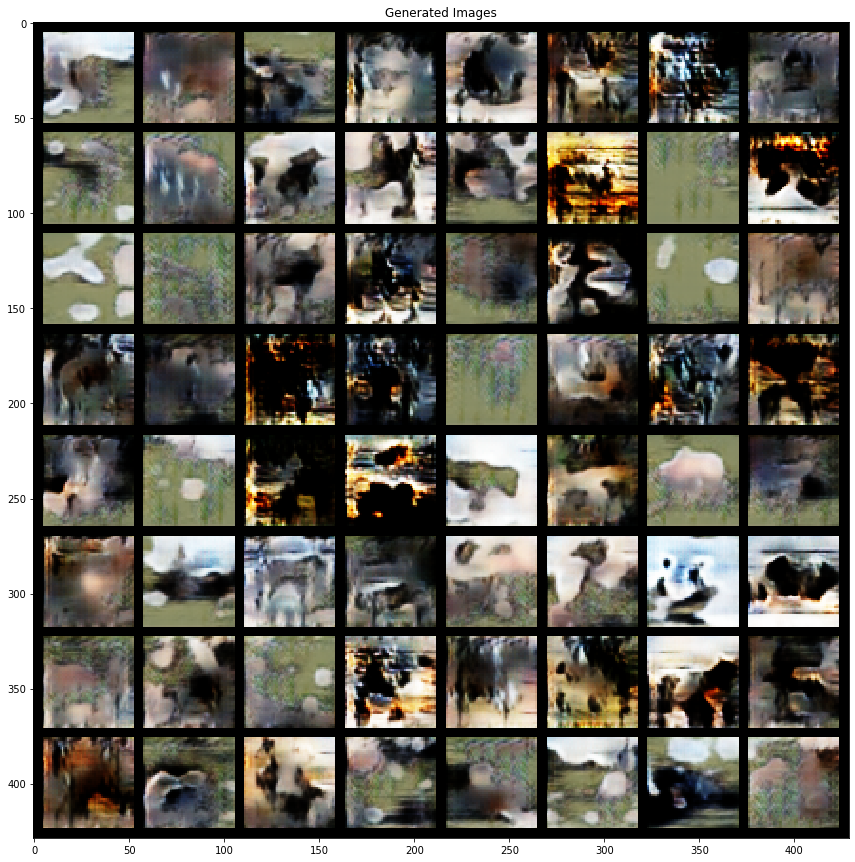

In [4]:
# Get the saved models
path = pathlib.Path("./best_models_convnet/")
model_paths = list(path.glob('*.pt'))

## Here we load the best model
best_idx = np.argsort(np.array([int(str(item).split(".")[0].split("_")[-1]) for item in model_paths]))[-1]
model_path = model_paths[best_idx]

model = load_model(model_path)
model.eval()

# 'eval_model' handles all of the job of evaluating the model and generating samples.
is_mean, is_std, fid = eval_model(model, dataroot, 10240, device, "./generated_samples_convnet")


# SphereGAN ResNet Training

In [4]:
# We set the seed and initialize our models in this cell.

manual_seed = 101
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genResnet = GeneratorResNet().to(device)

torch.manual_seed(manual_seed)
disResnet = DiscriminatorResNet().to(device)

torch.manual_seed(manual_seed)
genResnet.apply(weights_init)

torch.manual_seed(manual_seed)
disResnet.apply(weights_init)


DiscriminatorResNet(
  (conv1): conv3x3(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (rb1): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
    (conv_shortcut): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (relu2): LeakyReLU(negative_slope=0.2)
    (ln1): LayerNorm(torch.Size([256, 48, 48]), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm(torch.Size([256, 24, 24]), eps=1e-05, elementwise_affine=True)
    (conv_1): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (avg_pool2): AdaptiveAvgPool2d(output_size=(24, 24))
  )
  (rb2): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(12, 12))
    (conv_shortcut): Conv2d(256, 256, kernel_size

In [5]:
# Prep the dataloader and optimizers
optimizerGenResnet = optim.Adam(genResnet.parameters(), lr=lr, betas=(beta1, beta2))
optimizerDiscResnet = optim.Adam(disResnet.parameters(), lr=lr, betas=(beta1, beta2))

dataloader_resnet = get_stl10_dataloader(dataroot, batch_size, workers, image_size)

# Keep track of best IS score during training.
best_is_resnet = [0,0]

img_list_resnet = []
G_losses_resnet = []
D_losses_resnet = []
iters_resnet = 0

# We use only the first moment according to the authors' reply to our mail, unlike what they suggest in the paper.
moments_resnet = 1

Files already downloaded and verified


In [ ]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_resnet, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disResnet.zero_grad()
        label = torch.full((batch_size,1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disResnet(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genResnet(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disResnet(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments_resnet, device)
        
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerDiscResnet.step()

        ############################
        # (2) Update Generator
        ###########################
        genResnet.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disResnet(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerGenResnet.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader_resnet),
                     error_disc.item(), error_gen.item()))

        G_losses_resnet.append(error_gen.item())
        D_losses_resnet.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters_resnet % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_resnet)-1)):
            
            genResnet.eval()
            with torch.no_grad():
                fake_images = genResnet(fixed_noise.to(device)).detach().cpu()
            img_list_resnet.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
            # To calculate IS for validation, switch models to cpu and inception to gpu.
            genResnet = genResnet.cpu()
            disResnet = disResnet.cpu()
            inception_net = inception_net.to(device)
   
            
            _is = inception_score_val(fake_images, inception_net, device)
            print("Iter:", iters_resnet,  "Inception Score:", _is, "\n")
            if (_is[0] > 2.0 and best_is_resnet[0] == 0) or (_is[0] > best_is_resnet[0] and best_is_resnet[0] != 0):
                best_is_resnet = _is
                torch.save({
                    'epoch': epoch,
                    'gen_state_dict': genResnet.state_dict(),
                    'gen_optimizer_state_dict': optimizerGenResnet.state_dict(),
                    'dis_state_dict': disResnet.state_dict(),
                    'dis_optimizer_state_dict': optimizerDiscResnet.state_dict(),
                    'img_list': img_list_resnet,
                    'inception_score': best_is_resnet
                    }, './checkpoints/resnet_state_dict_{}'.format(epoch))

                save_model(genResnet, "./best_models_resnet/model_{}.pt".format(epoch))
            
            # switch back.
            inception_net = inception_net.cpu()
            genResnet = genResnet.to(device)
            disResnet = disResnet.to(device)
         
            # Save generated images from the fixed noise
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list_resnet[-1],(1,2,0)))
            plt.savefig("./figures/progress/resnet_fake_iter_{}.svg".format(iters_resnet))
            plt.clf()
            
            genResnet.train()


        iters_resnet += 1

# Training is finished. Lets plot and save the loss we've collected.
plot_loss(G_losses_resnet, D_losses_resnet, "./figures/resnet_loss.svg")

[0/1300][0/78]	Loss_D: 0.0003	Loss_G: 0.0049
Iter: 0 Inception Score: (1.6999948102853615, 0.19591741845827307) 

[0/1300][50/78]	Loss_D: -0.0004	Loss_G: 0.0038
[1/1300][0/78]	Loss_D: -0.0002	Loss_G: 0.0018
[1/1300][50/78]	Loss_D: -0.0005	Loss_G: 0.0085
[2/1300][0/78]	Loss_D: -0.0003	Loss_G: 0.0047
[2/1300][50/78]	Loss_D: -0.0040	Loss_G: 0.0042
[3/1300][0/78]	Loss_D: -0.0003	Loss_G: 0.0072
[3/1300][50/78]	Loss_D: -0.0000	Loss_G: 0.0011
[4/1300][0/78]	Loss_D: -0.0001	Loss_G: 0.0012
[4/1300][50/78]	Loss_D: 0.0000	Loss_G: 0.0043
[5/1300][0/78]	Loss_D: -0.0058	Loss_G: 0.0137
[5/1300][50/78]	Loss_D: 0.0000	Loss_G: 0.0009
[6/1300][0/78]	Loss_D: 0.0000	Loss_G: 0.0010
Iter: 500 Inception Score: (1.444609437475322, 0.20537635537714086) 

[6/1300][50/78]	Loss_D: -0.0010	Loss_G: 0.0023
[7/1300][0/78]	Loss_D: -0.0010	Loss_G: 0.0076
[7/1300][50/78]	Loss_D: -0.0004	Loss_G: 0.0057
[8/1300][0/78]	Loss_D: -0.0000	Loss_G: 0.0016
[8/1300][50/78]	Loss_D: 0.0000	Loss_G: 0.0020
[9/1300][0/78]	Loss_D: -0.000

[77/1300][50/78]	Loss_D: -0.0419	Loss_G: 0.0457
[78/1300][0/78]	Loss_D: -0.0459	Loss_G: 0.0838
[78/1300][50/78]	Loss_D: -0.0412	Loss_G: 0.1508
[79/1300][0/78]	Loss_D: -0.0383	Loss_G: 0.1701
[79/1300][50/78]	Loss_D: -0.0273	Loss_G: 0.0837
[80/1300][0/78]	Loss_D: -0.0179	Loss_G: 0.1387
[80/1300][50/78]	Loss_D: -0.0182	Loss_G: 0.0898
[81/1300][0/78]	Loss_D: -0.0059	Loss_G: 0.0446
[81/1300][50/78]	Loss_D: -0.0260	Loss_G: 0.1476
[82/1300][0/78]	Loss_D: -0.0397	Loss_G: 0.0118
[82/1300][50/78]	Loss_D: -0.0077	Loss_G: 0.1705
[83/1300][0/78]	Loss_D: -0.0256	Loss_G: 0.0783
Iter: 6500 Inception Score: (2.1637012912835294, 0.3389641209342256) 

[83/1300][50/78]	Loss_D: -0.0609	Loss_G: 0.1834
[84/1300][0/78]	Loss_D: -0.0347	Loss_G: 0.1497
[84/1300][50/78]	Loss_D: -0.0302	Loss_G: 0.1178
[85/1300][0/78]	Loss_D: -0.0455	Loss_G: 0.0313
[85/1300][50/78]	Loss_D: -0.0258	Loss_G: 0.1660
[86/1300][0/78]	Loss_D: -0.0318	Loss_G: 0.1112
[86/1300][50/78]	Loss_D: -0.0160	Loss_G: 0.1122
[87/1300][0/78]	Loss_D: -0

Generating images...
Saving real images...
Files already downloaded and verified
Calculating IS...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
Calculating FID...
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
0 / 10240
1024 / 10240
2048 / 10240
3072 / 10240
4096 / 10240
5120 / 10240
6144 / 10240
7168 / 10240
8192 / 10240
9216 / 10240
IS: 5.448782636885578 0.13997867851610815
FID: 65.62382219376093


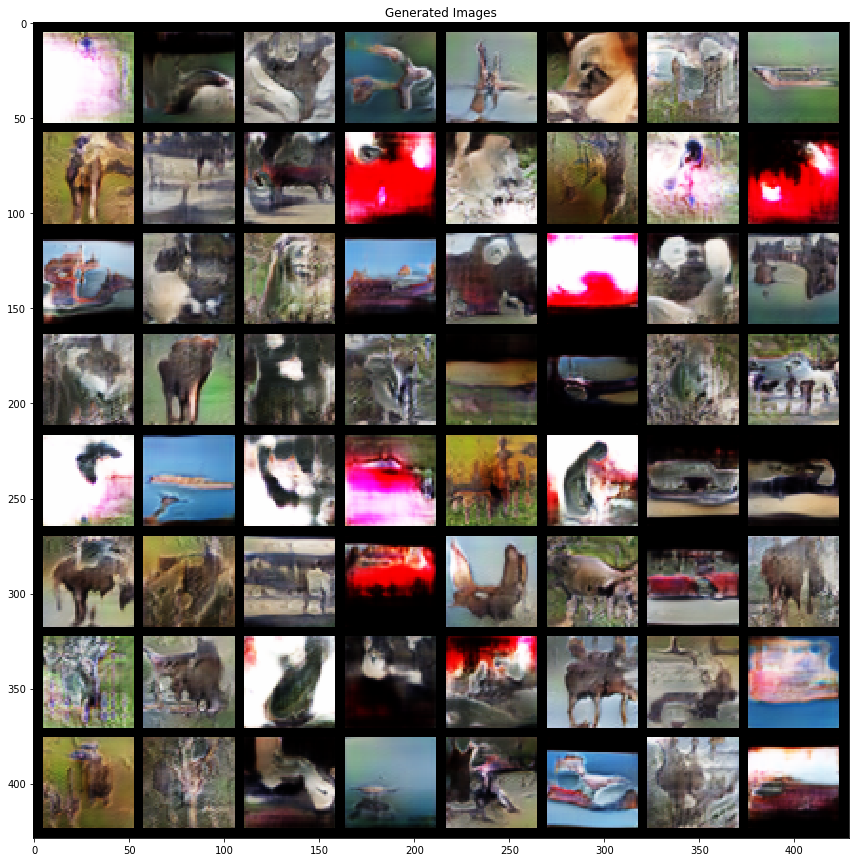

In [11]:
# Get the saved models

path = pathlib.Path("./best_models_resnet/")
model_paths = (list(path.glob('*.pt')))

# Load the best model
best_idx = np.argsort(np.array([int(str(item).split(".")[0].split("_")[-1]) for item in model_paths]))[-1]
model_path = model_paths[best_idx]

model = load_model(model_path)
model.eval()

# 'eval_model' handels IS and FID calculation and sampling with the given best model
is_mean, is_std, fid = eval_model(model, dataroot, 10240, device, "./generated_samples_resnet")
